<a href="https://colab.research.google.com/github/RoboTuan/MML/blob/main/dry_beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.utils import io

with io.capture_output() as captured:
  !apt install texlive-fonts-recommended;
from IPython.display import Image
from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introduction and Problem Specification

*In this work I will analyze the **Dry Beans** dataset as a multiclass classification problem, trying different classifiers and combining several pre-processing techniques.*  

In the original study[11], the authors propose a novel dataset and a computer vision system that extracts features from images of beans and eases the classification process. Seed quality is essential for crop production and marketing purposes, but, as the authors specify, dry beans cultivation in Turkey is often of mixed species. This kind of cultivation (referred to as population cultivation) could be disadvantageous for the producer if the beans species are not separated before entering the market, reducing their value. A possible solution could be to manually identify and label the mixed bean population, but this requires time resources and it is error-prone. However, since dry bean varieties (and therefore their value) are determined by considering the form, shape, type, structure given by the Turkish Standards Institute and the market situation, the authors' computer vision system extracts dimensional and shape features in line with the product parameters that will determine the beans price. The seven most well known Turkish dry bean varieties are: **Barbunya**, **Bombay**, **Cali**, **Dermason**, **Horoz**, **Seker** and **Sira**. Below there is a brief description and an image of each species as reported in the original study.  

![varieties](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/varieties.jpg)

* **Cali**: it is white in color, its seeds are slightly plump and slightly larger and have shape of kidney.
* **Horoz**: dry beans of this type are long, cylindrical, white in color and generally medium in size.
* **Dermason**: this type of dry beans, which are fuller flat, is white in color and one end is round and the other ends are round.
* **Seker**: large seeds, white in color, physical shape is round.
* **Bombay**; It is white in color, its seeds are very big and its physical structure is oval and bulging.
* **Barbunya**: beige-colored background with red stripes or variegated, speckled color, its seeds are large, physical shape is oval close to the round.
* **Sira**: its seeds are small, white in color, physical structure is flat, one end is flat, and the other end is round.  

Since we can translate this problem into a multiclass classification one, it is possible to use machine learning techniques to classify dry bean seeds by exploiting the features extracted by the authors of the dataset. As it is stated in their work, **they obtained one kilogram of the seven varieties from certified seed producers**. Then, they took pictures of the dry beans by using their special system (for ideal illumination) by placing multiple seeds of the same species together. From the 236 images, there were segmented 13,611 dry bean samples. The image processing pipeline includes shadow, background and noise removal prior to the bean segmentation (separating the beans in the same image). Finally, the images are first converted into grayscale and then to binary. As written in their study, this process does not compromise the quality of prediction since, as we can see from the previous image, the different seed varieties do not have distinctive color features. Below the extracted features with a brief description are presented. They consist of 12 dimensional and 4 shape features for each dry bean (a total of 16), their values are in number of pixels.  


1. **Area** (**A**): The area of a bean zone and the number of pixels within its boundaries.   
2. **Perimeter** (**P**): Bean circumference is defined as the length of its border.
3. **Major axis length** (**L**): The distance between the ends of the longest line that can be drawn from a bean.
4. **Minor axis length** (**l**): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
5. **Aspect ratio** (**K**): Defines the relationship between **L** and **l**.  
$K = \frac{L}{l}$  

6. **Eccentricity** (**Ec**): Eccentricity of the ellipse having the same moments as the region.
7. **Convex area** (**C**): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
8. **Equivalent diameter** (**Ed**): The diameter of a circle having the same area as a bean seed area.  
$Ed = \sqrt{\frac{4*A}{\pi}}$  

9. **Extent** (**Ex**): The ratio of the pixels in the bounding box to the bean area.  
$Ex = \frac{A}{A_{B}}$ where $A_{B}$ is the area of the bounding rectangle.  

10. **Solidity** (**S**): Also known as convexity.  
$S = \frac{A}{C}$  

11. **Roundness** (**R**): Calculated with the following formula:  
$R = \frac{4*\pi*A}{P^{2}}$  

12. **Compactness** (**CO**): Measures the roundness of an object:  
$CO = \frac{Ed}{L}$  

13. **ShapeFactor1** (**SF1**) $ = \frac{L}{A}$

14. **ShapeFactor2** (**SF2**) $ = \frac{l}{A}$

15. **ShapeFactor3** (**SF3**) $ = \frac{A}{\frac{L}{2}*\frac{L}{2}*\pi}$

16. **ShapeFactor4** (**SF4**) $ = \frac{A}{\frac{L}{2}*\frac{l}{2}*\pi}$






In [ ]:
!pip uninstall --quiet scikit-learn -y
!pip install -U --quiet scikit-learn

!pip uninstall --quiet imbalanced-learn -y
!pip install -U --quiet imbalanced-learn

In [ ]:
# check scikit-learn and version
import sklearn
#print('sklearn: %s' % sklearn.__version__)

In [ ]:
# Utils and numerical
import numpy as np
import pandas as pd
import os
import sys
import copy

# Visualizations
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imbalanced Sklearn
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [ ]:
if not os.path.isfile("./DryBeanDataset.zip"):
  !wget -q http://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip

if not os.path.isdir("./DryBeanDataset"):
  !unzip -q "./DryBeanDataset.zip"

if not os.path.isfile("./Dry_Bean_Dataset.xlsx"):
  !cp "./DryBeanDataset/Dry_Bean_Dataset.xlsx" .

# Data Exploration and Outliers Detection

The dataset does not contain any missing values and has only real and integer (counting the number of pixels) variables. Before performing any analysis, the dataset was split into a training and a test set with a ratio of $70/30$. The stratified sampling assures that the relative class frequencies are approximately preserved[12] in the splitted data. All the following techniques were applied only on the training set, while the test data was preserved untouched until the final evaluation.  

In [ ]:
raw_data = pd.read_excel("./Dry_Bean_Dataset.xlsx")
classes = raw_data["Class"]
beans = raw_data.drop(columns=["Class"])
random_state = 42
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(beans, classes, test_size=0.30, stratify=classes, shuffle=True, random_state=random_state)
# Dataframe with labels useful for the plots

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_train_statistics = pd.DataFrame(np.concatenate((X_train, np.expand_dims(y_train, axis=0).T), axis=1), columns = raw_data.columns)

X_train_statistics = X_train.assign(Class=y_train.values)
print(f"Total training samples: {X_train.shape[0]}")
print(f"Total test samples: {X_test.shape[0]}")

X_train_statistics.head()

Total training samples: 9527
Total test samples: 4084


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
12563,34861,699.286,257.159639,172.838987,1.487857,0.740453,35324,210.680810,0.718635,0.986893,0.895860,0.819261,0.007377,0.002050,0.671188,0.998632,DERMASON
6172,51106,887.937,369.488627,176.544117,2.092897,0.878465,51520,255.088573,0.689801,0.991964,0.814549,0.690383,0.007230,0.001013,0.476628,0.997534,HOROZ
1221,40504,740.479,245.541736,210.426187,1.166878,0.515337,40946,227.093141,0.763190,0.989205,0.928287,0.924866,0.006062,0.002736,0.855377,0.998120,SEKER
827,38222,709.963,246.270525,197.703616,1.245655,0.596261,38555,220.603177,0.780774,0.991363,0.952910,0.895776,0.006443,0.002559,0.802414,0.999531,SEKER
10774,27765,610.322,221.260099,160.236692,1.380833,0.689589,28057,188.019935,0.809806,0.989593,0.936676,0.849769,0.007969,0.002563,0.722107,0.997109,DERMASON


In [ ]:
X_train.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000
mean,52969.300619,854.654448,319.889593,202.158035,1.582808,0.750886,53689.755747,252.894574,0.749464,0.987108,0.873345,0.799923,0.006566,0.001717,0.643667,0.995030
std,29244.521479,213.716254,85.445223,44.895723,0.246015,0.091677,29690.440866,59.053439,0.049033,0.004742,0.059441,0.061561,0.001125,0.000596,0.098746,0.004459
min,20420.000000,524.736000,183.601165,122.512653,1.036423,0.262774,20684.000000,161.243764,0.566768,0.919246,0.489618,0.640577,0.002778,0.000567,0.410339,0.947687
25%,36253.000000,702.701500,253.066105,175.706979,1.433080,0.716295,36647.500000,214.845882,0.718228,0.985607,0.832397,0.762624,0.005913,0.001158,0.581596,0.993687
50%,44691.000000,795.147000,297.398542,192.467288,1.550935,0.764374,45217.000000,238.542131,0.759341,0.988275,0.883061,0.801304,0.006645,0.001690,0.642088,0.996380
75%,61311.000000,976.030500,375.897556,216.449332,1.705926,0.810172,62324.500000,279.398621,0.786660,0.990013,0.916807,0.833928,0.007277,0.002172,0.695436,0.997877
max,248424.000000,1895.940000,726.373493,460.198497,2.430306,0.911423,251082.000000,562.408446,0.866195,0.994677,0.990685,0.981611,0.010451,0.003665,0.963560,0.999733


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9527 entries, 12563 to 3510
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             9527 non-null   int64  
 1   Perimeter        9527 non-null   float64
 2   MajorAxisLength  9527 non-null   float64
 3   MinorAxisLength  9527 non-null   float64
 4   AspectRation     9527 non-null   float64
 5   Eccentricity     9527 non-null   float64
 6   ConvexArea       9527 non-null   int64  
 7   EquivDiameter    9527 non-null   float64
 8   Extent           9527 non-null   float64
 9   Solidity         9527 non-null   float64
 10  roundness        9527 non-null   float64
 11  Compactness      9527 non-null   float64
 12  ShapeFactor1     9527 non-null   float64
 13  ShapeFactor2     9527 non-null   float64
 14  ShapeFactor3     9527 non-null   float64
 15  ShapeFactor4     9527 non-null   float64
dtypes: float64(14), int64(2)
memory usage: 1.2 MB


## Class representation

As it can be seen from the *count plot*, the seed distribution is not uniform in terms of the number of different samples. The *Dermason* bean variety represents more than $26\%$ of the training samples, while the *Bombay* species accounts only for less than $4\%$ of the total training samples. The authors of the dataset collected $1 kg$ of seeds for each bean variety. However, seeds have different sizes. Looking at the mean area, for the *Dermason* species is approximately $32069$ pixels, while for the *Bombay* variety is approximately $173260$ pixels. This has led to an imbalanced dataset in which small beans are overrepresented while the big ones are underrepresented. 


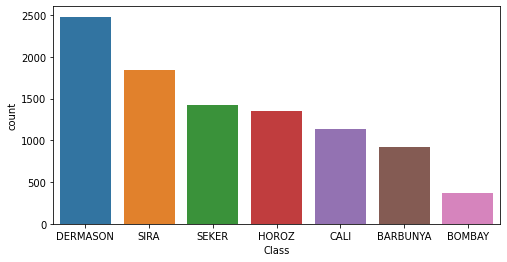

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(ax=ax, x="Class", data=X_train_statistics, order = X_train_statistics["Class"].value_counts().index)
plt.show()

In [ ]:
#class_cardinality = X_train_statistics.value_counts(subset=["Class"])
class_cardinality = y_train.value_counts()

mean_class_cardinality = y_train.value_counts().mean()

print(f"Class distribution statistics:")
for bean, freq in class_cardinality.iteritems():
  print(f"{bean} {freq} {freq*100/X_train.shape[0]:.2f}%")
print()

print(f"Mean class cardinality = {mean_class_cardinality}")

Class distribution statistics:
DERMASON 2482 26.05%
SIRA 1845 19.37%
SEKER 1419 14.89%
HOROZ 1350 14.17%
CALI 1141 11.98%
BARBUNYA 925 9.71%
BOMBAY 365 3.83%

Mean class cardinality = 1361.0


In [ ]:
dermason_train = X_train_statistics.loc[(X_train_statistics["Class"]=="DERMASON"), ["Area"]]
bombay_train = X_train_statistics.loc[(X_train_statistics["Class"]=="BOMBAY"), ["Area"]]

print(f"Mean seed area for dermason beans: {float(dermason_train.mean()):.2f} pixels")
print(f"Mean seed area for bombay beans: {float(bombay_train.mean()):.2f} pixels")

Mean seed area for dermason beans: 32069.03 pixels
Mean seed area for bombay beans: 173260.26 pixels


## Outlier detection

### Boxplots

*Boxplots* provide useful summary statistics. As it is possible to see from the following plots, the vertical line inside the box represents the median or second quartile ($50^{th}$ percentile), while the left and right edges respectively represent the first quartile ($25^{th}$ percentile) and third quartile ($75^{th}$ percentile). The difference between the third and first quartile represented by the box is called *interquartile range* (IQR) and the lines that extend up until a vertical *fence* are called *whiskers*. In this setting, the whiskers can extend up to $Q1 - 1.5*IQR$ (*lower fence*) or $Q3 + 1.5*IQR$ (*upper fence*). However, if we consider the data that is between those two values, we only extend the *whiskers* up to the two data points that are the closest to the *upper* and *lower fence*. The two selected data points are often called *minimum* and *maximum* respectively, which are not the minimum and maximum values of the data. The data that lies outside those two fences is considered an outlier and it is often depicted with dots.

In [ ]:
# # Boxplots with standardized data for all the features

# scaler = StandardScaler()
# X_train_std = scaler.fit_transform(X_train)
# X_train_statistics_std = pd.DataFrame(np.concatenate((X_train_std, np.expand_dims(y_train, axis=0).T), axis=1), columns = raw_data.columns)

# plt.figure(figsize=(20,10))
# X_train_statistics_std = X_train_statistics_std.iloc[:, :-1]
# _ = sns.boxplot(data=X_train_statistics_std, orient = "h")

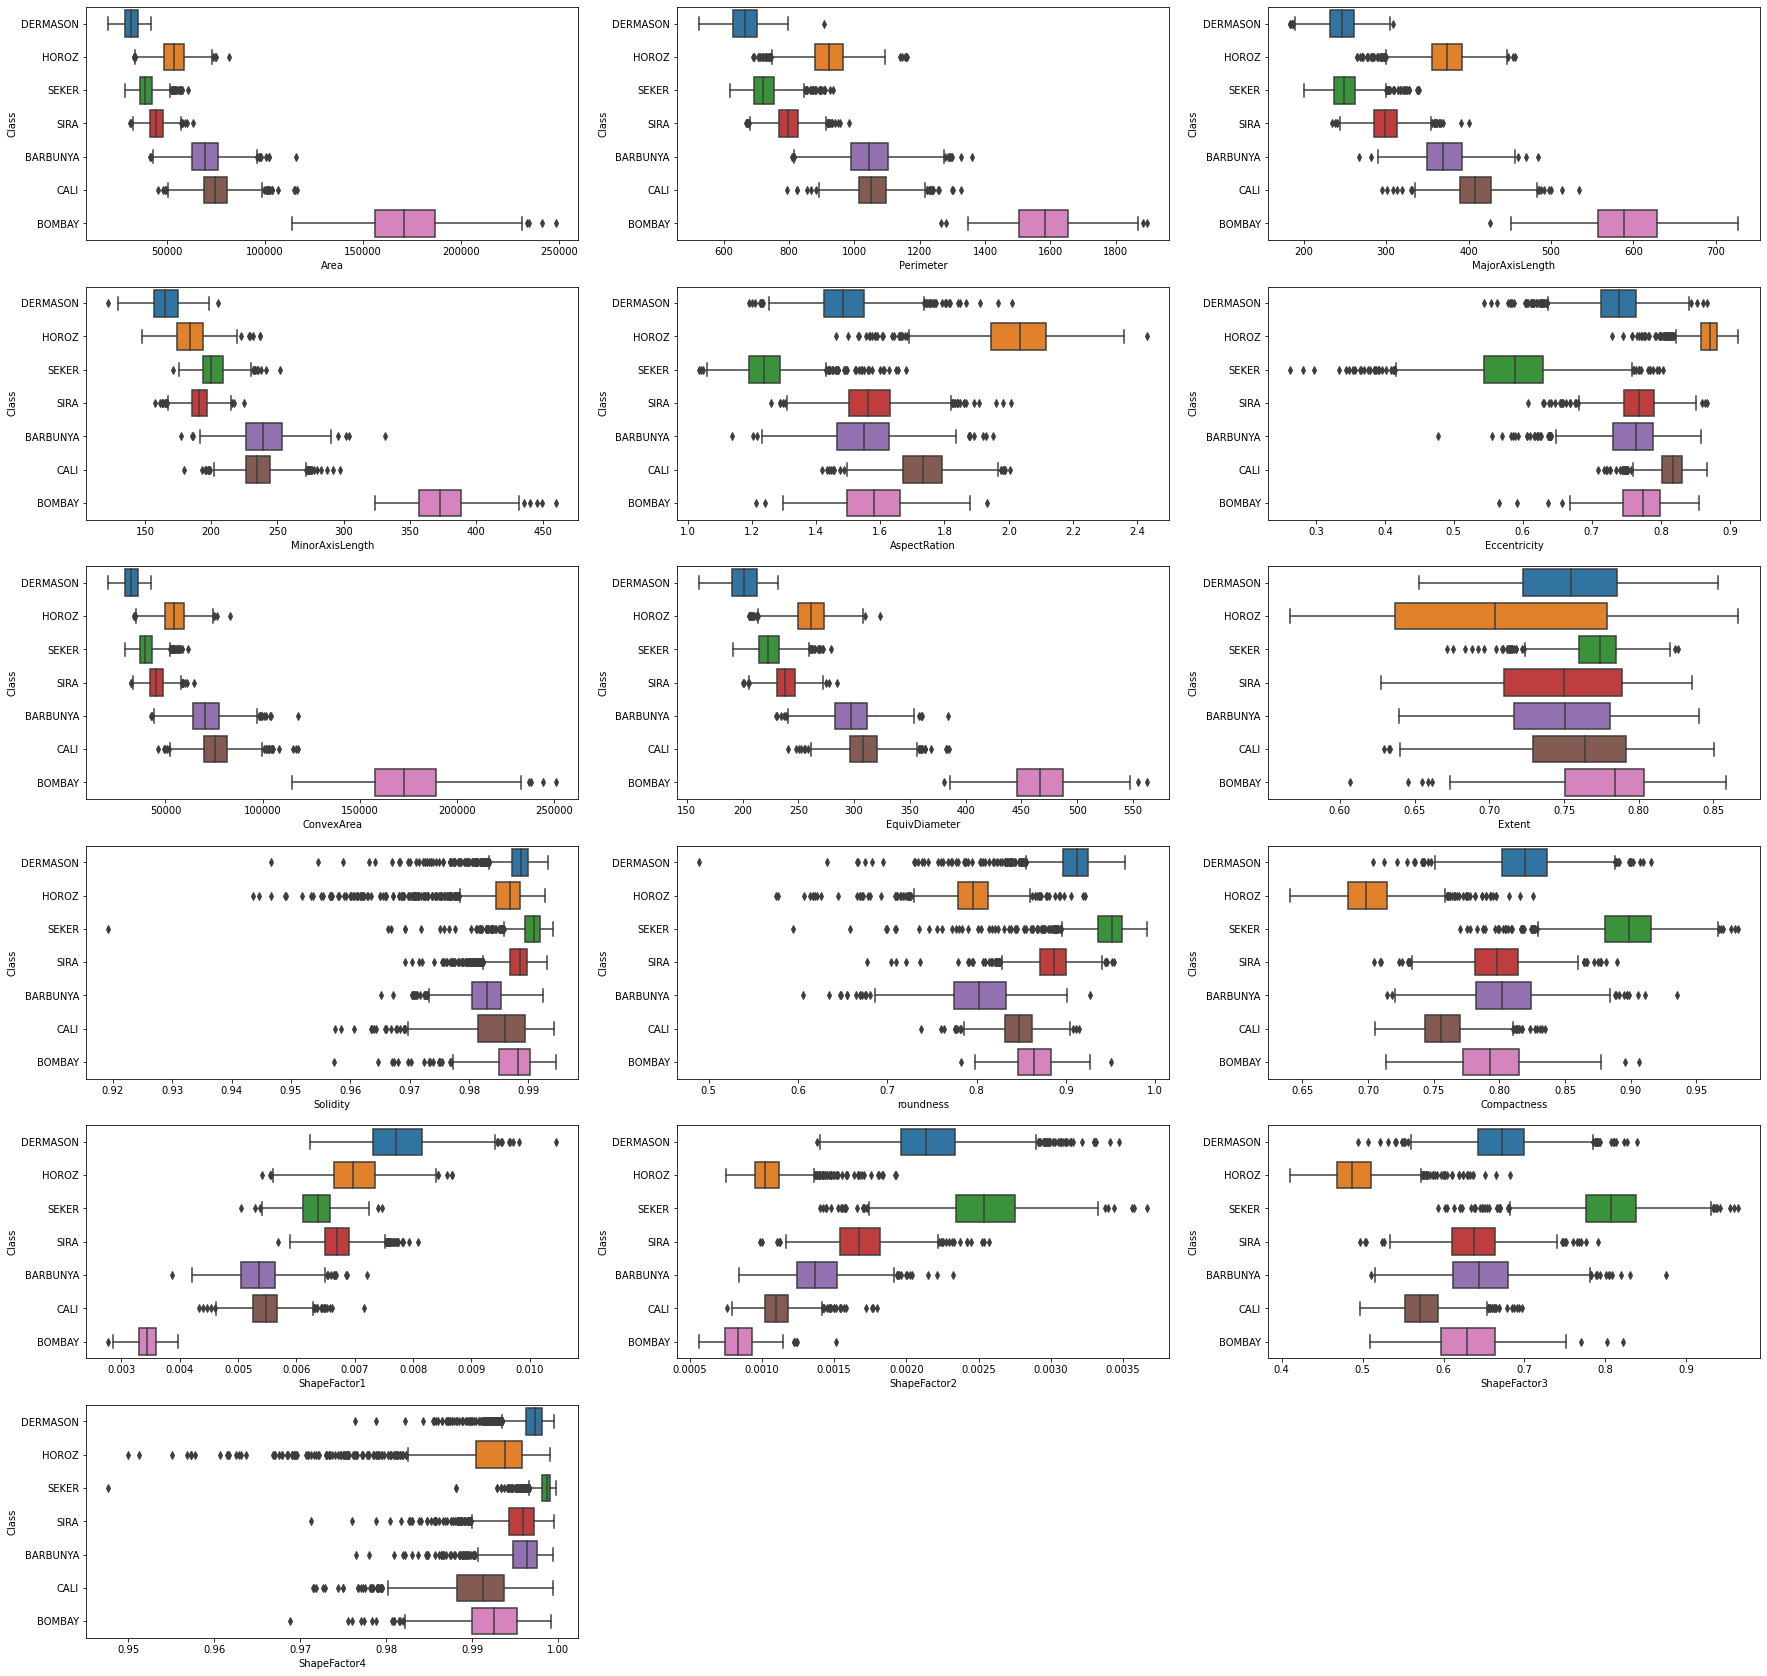

In [ ]:
# Boxplots for each feature with respect to the classes

n_rows_graph = 6
n_cols_graph = 3
n_features = X_train_statistics.shape[1] - 1 # one is the class which is not a feature
fig, axes = plt.subplots(n_rows_graph, n_cols_graph, figsize=(30, 30))

for i in range(n_rows_graph):
  for j in range(n_cols_graph):
    if i*n_cols_graph + j >= n_features:
      break
    sns.boxplot(ax=axes[i][j], x=X_train_statistics.iloc[:, i*n_cols_graph + j], y="Class", whis=1.5, data=X_train_statistics)

fig.delaxes(axes[5][1])
fig.delaxes(axes[5][2])

plt.show()

### Isolation Forest

*Isolation Forest*[13] is a model-based method that explicitly isolates anomalies instead of profiling normal instances. The authors state that this method takes advantage of the assumption that anomalies consist of fewer instances and they have attribute values that are very different from those of normal instances.  
It selects a random subsample of our data for each *isolation tree* and, for each of those, it recursively partitions the data space as follows. We randomly select a random attribute and a random cut-point for the split, until all instances are isolated, a height limit is reached or the remaining instances all have the same value. If a point was isolated with few partitions, it will be nearer to the root of the tree and thus, anomalies have shorter path lengths. Instead of relying on just one tree, we create an ensamble of trees for obtaining more robust path lengths by averaging among all the trees.  
The algorithm returns an anomaly score $s$ interpretable as follows:
* if instances return $s$ very close to $1$, then they are anomalies,
* if instances have $s$ much smaller than $0.5$, then they are quite safe to be regarded as normal instances,
* if all the instances return $s \approx 0.5$, then the entire sample does not have any distinct anomaly.  

Among others, we can choose how many samples to draw from the original data for each estimator, the threshold that defines the maximal percentage of outliers with respect to the total data and the number of estimators.  
With a threshold of $10 \%$, it is possible to see from the following *boxplots* that the most extreme instances were removed.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Outliers detected with isolation forest: 953


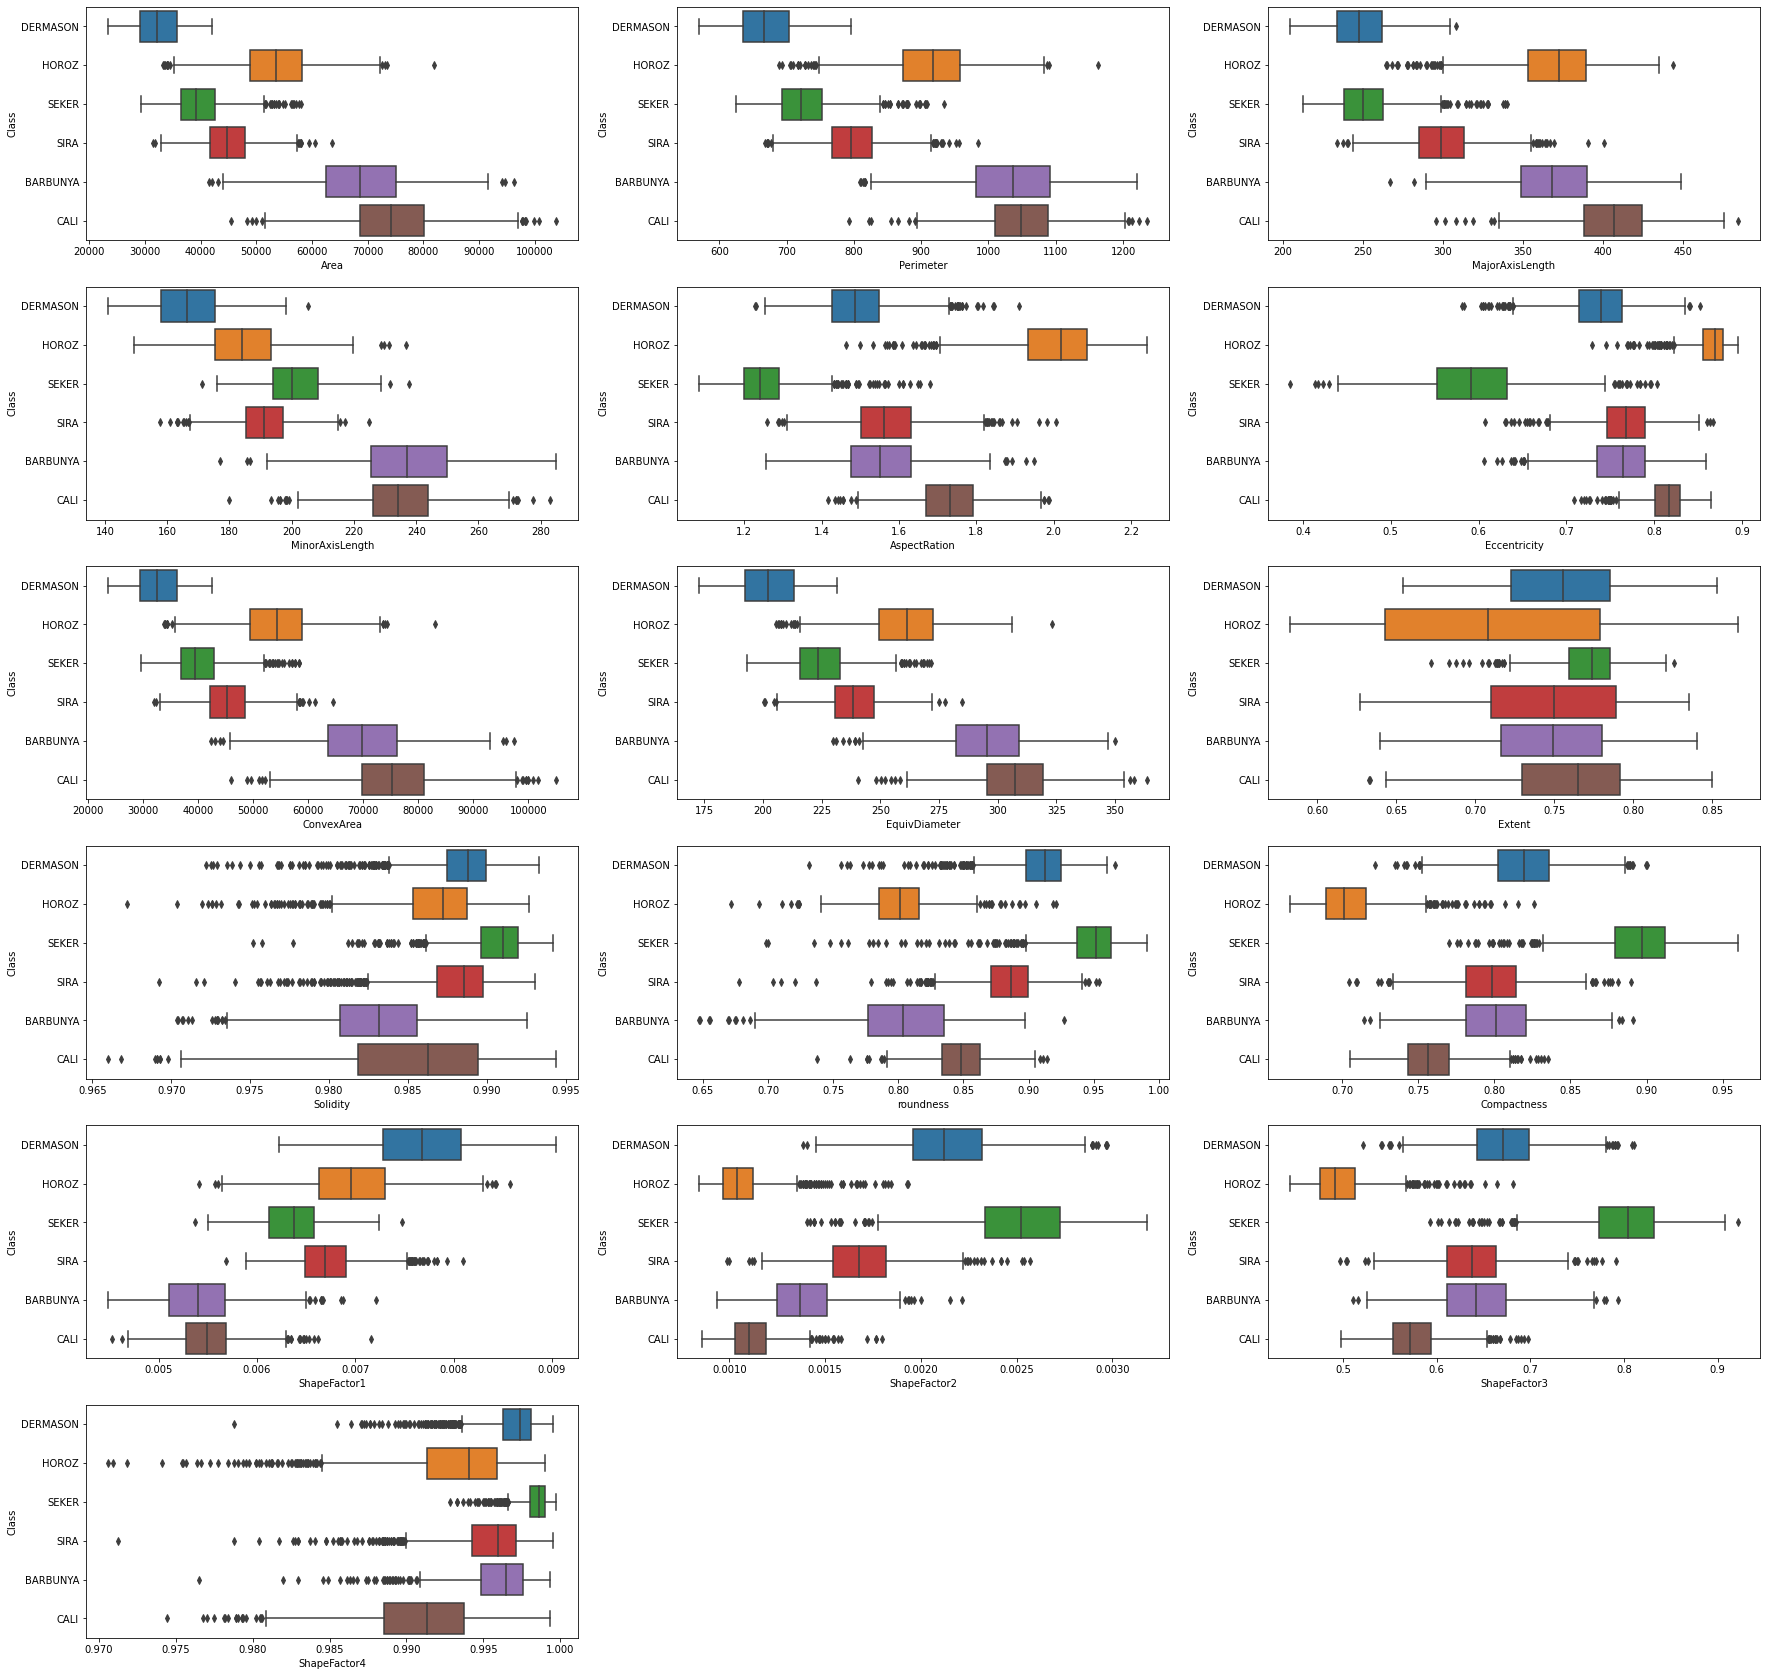

In [ ]:
IF = IsolationForest(contamination=0.1, random_state=random_state, n_jobs=-1)
outliers_X_train = IF.fit_predict(X_train)
print(f"Outliers detected with isolation forest: {np.count_nonzero(outliers_X_train == -1)}")
#np.count_nonzero(outliers_X_train == -1) * 100 / X_train.shape[0]
outliers_X_train = outliers_X_train == 1
X_out = X_train[outliers_X_train]
y_out = y_train[outliers_X_train]
X_out = X_out.assign(Class=y_out.values)

# Boxplots for each feature with respect to the classes
n_rows_graph = 6
n_cols_graph = 3
n_features = X_out.shape[1] - 1 # one is the class which is not a feature
fig, axes = plt.subplots(n_rows_graph, n_cols_graph, figsize=(30, 30))

for i in range(n_rows_graph):
  for j in range(n_cols_graph):
    if i*n_cols_graph + j >= n_features:
      break
    sns.boxplot(ax=axes[i][j], x=X_out.iloc[:, i*n_cols_graph + j], y="Class", whis=1.5, data=X_out)

fig.delaxes(axes[5][1])
fig.delaxes(axes[5][2])

plt.show()

Theese techniques were able to highlight quite a few outliers. However, in the authors' study there was no specification on how to treat them. In particular, it was stated that **they obtained one kilogram of the seven bean varieties from certified seed producers**. Thus, I decided not to remove them and consider the whole dataset for classification analysis.

## Feature correlations

As we observed in the initial sections, the features are often a compound of themselves and, more in general, they appear to be *related*. One can measure the linear relationship among features with the **Pearson’s correlation coefficient**. In the following correlation matrix, each entry is as follows:
$$
\rho_{X, Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}
$$
where $X, Y$ are two feature vectors, $cov(X,Y)$ is their sample covariance and $\sigma_X \sigma_Y$ their sample standard deviation. Each of these coefficients lives in the range $[-1, +1]$. If it is near zero, the two feature vectors are not correlated, while, if it is near plus or minus one they are strongly correlated. When the correlation is positive, the linear relationship is direct, while if it is negative, the relationship is inverse.  
In this case-study, several feature vectors are correlated. However, instead of using this tool for feature selection, **PCA** will be applied to the entire dataset. Then, a satisfying number of **principal components** will be chosen as new predictors.

In [ ]:
#sns.pairplot(X_train_statistics, hue='Class')
#plt.show()

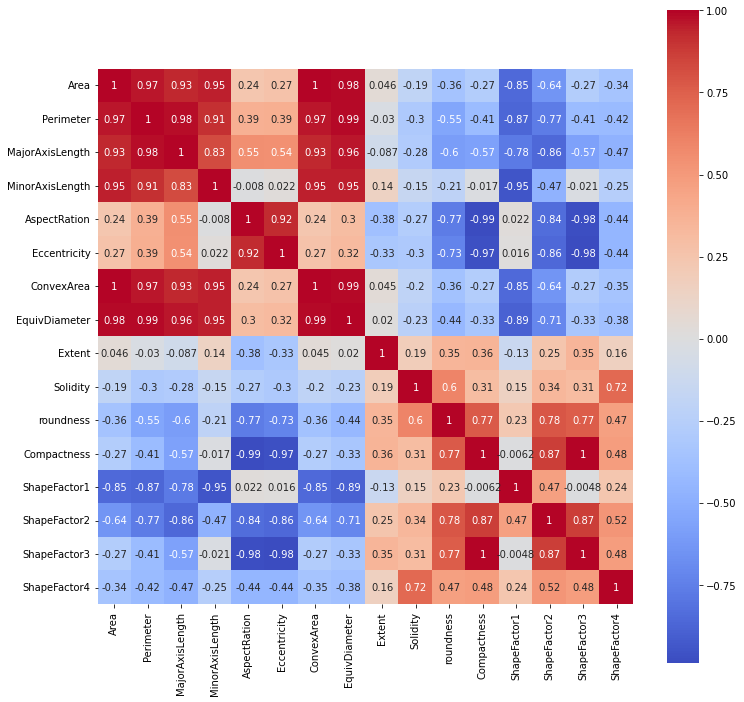

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(X_train.corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

# Data Preparartion and Dimensionality Reduction

## Standardization

Both the mean and standard deviation vary greatly among the features. As mentioned in [9], in distance-based algorithms, having the same scale between the features is fundamental since it avoids assigning more importance on attributes with a broader range and leads to equal footing. On top of this, gradient based implementations converge much faster with feature scaling rather than without (since we wouldn't have abnormal weight updating for features with a broader range).
The data has been standardized as follows: 
$$
x' = \frac{x- \bar x}{\sigma}
$$
from each feature remove the mean and scale to unit variance. This will not restrict the values to a particular range, but now each feature will have zero mean and unit variance, which is required by many algorithms.

In [ ]:
scaler = StandardScaler()

## Resampling

In this section we are going to explore two common methods to tackle data imbalance. In a binary classification setting, this phenomenon is common in anomaly detection. Usually, the datasets related to this task, such as *Credit Card Fraud Detection*, have far more samples of "normal" instances rather than anomalies. The issue is that we would like to correctly identify them but, if one had only less than 10% of the samples represented by anomalies, the model of choice could fail to learn a discriminative representation for such anomalies. Even worse, if we don't choose a proper metric, we could have more than 90% of *accuracy* by just always predicting "not anomaly".  
In the next paragraphs **Smote** and **RUS** are presented as resampling methods for the *dry beans* multi-class problem. A later section instead will be devoted for metric discussion. 

In [ ]:
# Since with stratified k-fold cross-validation I maintain the class distribution,
# I can consider '(n_splits-1)*mean_class_cardinality/n_splits' as the target for the
# resampling methods.
# This is because out of the 'n_splits' sets of data, we use 'n_splits-1' of them for training and
# the remaining one for validation. Smote and Rus are applied only on the training data.
# 

mean_target_classes = (n_splits-1) * mean_class_cardinality / n_splits


### Random Under Sampling

**Random Under Sampling (RUS)**[6] under-samples the majority class by taking samples out from it until a certain percentage is reached with respect to the minority class population. However, instead of considering only the majority and minority classes, we have different options such as resampling all but the minority or the majority. The most flexible alternative is to specify exactly which classes to under-sample and the desired number of samples for each targeted class. Reasonably, this number must be lower than the original population size.

In [ ]:
# Undersampling the classees that exceed mean_class_cardinality samples
undersampled_classes = dict()

# Search classes that have more than mean_class_cardinality samples
for c in class_cardinality[class_cardinality > mean_class_cardinality].index:
  undersampled_classes[c] = int(mean_target_classes)

rus = RandomUnderSampler(sampling_strategy=undersampled_classes, random_state=random_state)
#print(undersampled_classes)

### Smote

**Synthetic Minority Oversampling Technique (SMOTE)**[6] creates new synthetic datapoints in the "feature space". In the standard version, for each existing data point in the minority class, $k$ (in this case 5 as in the original paper) nearest neighbours are found (belonging to the same class). Then, by selecting one neighbour at random, we draw a line between the two concerned points. The new point is created by sampling a point in the segment (this is like choosing a number $\in [0,1]$ and doing a convex combination). This procedure is repeated until a certain proportion of the minority class with respect to the majority one is met. It is possible to use the same options as with **RUS** to handle multiple classes. The authors of work [6] claim that this approach effectively forces the decision region of the minority class to become more general, with respect to random over sampling. Below we can see a picture[10] of this process.
![surrogate_loss](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/smote.png)  


In [ ]:
## Oversampling (with SMOTE) the classees that have less than mean_class_cardinality samples
#oversampled_classes = dict()

## Search classes that have less than mean_class_cardinality samples
#for c in class_cardinality[class_cardinality < mean_class_cardinality].index:
#  oversampled_classes[c] = int(mean_target_classes)

# I need to do smote AFTER rus since I oversample all classes but the majority one (which it will have at max #mean_class_cardinality instances)
smote = RandomOverSampler(sampling_strategy='not majority', random_state=random_state)
#print(oversampled_classes)

### Combining Under and Over Sampling

Since the minority class (*Bombay*) accounts for less than 4% of the total samples, while, the majority one (*Dermason*), for more than 26%, **RUS** and **SMOTE** were combined not to generate too many artificial samples. On top of this, *data leakage* must be prevented. This occurs when information that would not be available at prediction time is used when building the model, as stated in [5]. In particular, we want to maintain the distribution of the test set untouched. This has already been taken care of by splitting the data at the beginning, but the same reasoning must be applied also in the cross-validation process. To summarize, in each cross-validation iteration, the $(k-1)$ folds that serve as training data will be balanced, while the left out one will have the original distribution of the data. This is done to mimic the behaviour of the real data, otherwise, we would be evaluating the models on a distribution that is not representative of the testing environment[8]. Another issue is that, during the same cross-validation iteration, if both the training and validation data were to be balanced, depending on the resampling procedure, it would be possible to encounter the same sample in both the training and validation sets, inflating the scores.  This was handled with the *Pipeline* object of the *Imbalanced-Learn* Python library. This process is summarized by the following picture[14] in a binary classification case, where the left part is wrong, while the right one is the correct procedure.

![wrong-vs-right](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/wrongVSright_cv.jpg)

Bearing all this in mind, the same approach of work [7] was followed for combining the two resampling methods. After computing the mean class cardinality, those classes that have more samples than this mean will be under-sampled, the contrary applies to the classes that have less samples. This has to be done in each iteration split with the effective class data cardinality. Since the samples are sampled in a stratified fashion for cross-validation, the mean for each iteration becomes: $\frac{(K - 1) \  \times \  mean\_class\_cardinality}{K}=1088$ with $K$ the number of cross-validation iterations. The classes (*Dermason*, *Sira*, *Seker*) that have more samples than this number are under-sampled so that they reach 1088 samples. Now, since the previous classes represent the new majority ones, it is possible to apply **SMOTE** on all but the majority classes. In the end, at each iteration, there will be $1088$ samples for each class.

## Dimensionality Reduction

All the issues that arise when we deal with high dimensional data are often subsumed as *\"the curse of dimensionality\"*. Rather than a matter of computational complexity, this phenomenon is about the geometrical structure of the space when the dimension is high. For instance, if we assume that our data lies in $[0, 1]^p$, to capture a fraction $s$ of the total hypercube volume we would need an edge of length $s^{\frac{1}{p}}$. This implies that to capture $10\%$ of the volume in a 10-dimensional hypercube, the edges must preserve $80\%$ of the original length. The consequences are that, in high dimensional spaces, points are isolated (space has a filament-like structure, is difficult to sample around it) and, therefore, neighbourhoods are no longer local.  
Among others, **Principal Component Analysis** is a commonly used technique to reduce the dimensionality of the data by means of linear mappings. Let $\pmb x_1, \pmb x_2, ..., \pmb x_m$ be the original vectors in $R^d$, we would like to find the matrix $W \in R^{n,d}$ with $n \lt d$ such that it induces the mapping $\pmb x \mapsto W \pmb x$ with $\pmb y = W \pmb x \in R^n$ being the lower representation of the data. On top of this, a second matrix $U \in R^{d,n}$ has to be computed so that we can reconstruct $\pmb x$ from the compressed vector $\pmb y$ as $\pmb{\tilde x} = U \pmb y$, with $\tilde x \in R^d$. Intuitively we would like to find a good low dimensional representation for our data so that $UV \approx I$.  
We can express this as a minimization problem where we retrieve a compression and reconstruction matrix for which the total squared distance (measuring the approximate recovery) between the original and recovered vectors is minimal:
$$
\underset{W \in R^{n,d}, U \in R^{d,n}}{argmin} \sum_{i=1}^{m} \| \pmb x_i - UW \pmb x_i \|_2^2.
$$  
Since $UW$ has rank $n$, its range is a n-dimensional subspace of $R^d$, which we can denote as $S$. The mapping $\pmb x \mapsto UW \pmb x$ moves $\pmb x$ into this subspace and we wish to find the point in this space which is the closest to the original $\pmb x$. This can be achieved by an orthogonal projection of $\pmb x$ on $S$. To do so, consider the matrix $V$ whose columns are an orthonormal basis of the subspace $S$, the orthogonal projection of $\pmb x$ on $S$ (the closest point) is represented by $VV^T \pmb x$. Without loss of generality we can assume that $W = U^T$ with $U$ having orthonormal columns.  
Furthermore, exploiting the so found results, it can be proven that the previous **PCA** formulation can be rewritten as:  

$$
\underset{U \in R^{d,n}: U^TU=I}{argmax} trace \bigg( U^T \bigg(\sum_{i=1}^{m} \pmb x_i \pmb x_i^T \bigg) U \bigg)
$$  
If we define the scatter matrix as $A=\sum_{i=1}^{m} \pmb x_i \pmb x_i^T$, let the n leading eigenvectors (corresponding to the n largest eigenvalues) of $A$ be $\pmb u_1, \pmb u_2, ...,\pmb u_n$. Then, the solution to the **PCA** problem is to set the columns of $U$ to the aforementioned n leading eigenvectors of $A$. The matrix $A$ is symmetric, thus it can be diagonalized as $A=VDV^T$, where $D$ is the diagonal matrix with the eigenvalues, while $V$ is an orthonormal basis of eigenvectors of $A$.  

To solve the same problem, instead of finding the subspace generated by the first k eigenvectors of the scatter matrix, it is possible to define a linear combination of the features $\pmb{pc}_i = X \pmb\phi_i$ that it is named **principal component**, with $X \in R^{m,d}$ being the data matrix and $\pmb\phi_i \in R^d$ being the **loading vector** relative to the $i^{th}$ **principal component**. We then iteratively for $i=1, 2, ..., d$ compute these new variables so that they have maximal variance and, at each step, they are uncorrelated with the previous ones. Since the variance of $\pmb{pc}_1$ is computed as $\pmb\phi_1^T X^TX \pmb\phi_1$, with  $A = X^TX$ the scatter matrix of the data, maximizing the variance of the first **principal component** translates into:  
\begin{equation}
\begin{aligned}
\max_{\pmb\phi_1 \in R^d} \quad & \pmb\phi_1^T A \pmb\phi_1\\
\textrm{s.t.} \quad & \pmb\phi_1^T \pmb\phi_1 = 1  
\end{aligned}
\end{equation}
The constraint ensures a convex domain so that we do not increase indefinitely the objective only by increasing the elements of the **loading vectors** that would result in an arbitrary large variance. The solution yields that $A \pmb\phi_1 = \lambda \pmb\phi_1$, with $\lambda$ being the Lagrangian multiplier associated to the equality constraint. This means that the **loading vector** is the eigenvector of $A$ associated to the eigenvalue $\lambda$. Since $\pmb\phi_1$ was constrained to have a unit norm, in the end, what we have to maximize is just $\lambda$, which is therefore equal to the variance explained by $\pmb{pc}_1$. Consequently, the solution is the eigenvector associated with the largest eigenvalue, which is unsurprisingly the same as that of the previous **PCA** formulation.  
For the remaining **principal components**, we solve iteratively the same problem, but with the following additional constraints: $\pmb\phi_i^T A \pmb\phi_j=0 \quad \forall j \lt i$ to ensure that the **loading vectors** are uncorrelated (orthogonal). Hence, they represent the direction in which the feature space varies the most.  

The notion of **principal components** lets us introduce the *scree plot*.Recalling that the total variance is equal to $trace(A)$ but also $\sum_{i=1}^d \lambda_i$, the *scree plot* is a Pareto chart where the bars identify the proportion of variance explained by each **principal component** namely $\frac{\lambda_i}{\sum_{i=1}^d \lambda_i}$, while the dotted line identifies the cumulative proportional variance up to a certain **principal component** $k$ namely $\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^d \lambda_i}$. As it is possible to see from the picture below, this chart can help us understand how many **principal components** retain for the rest of our analysis. In this case, 5 principal components were retained, accounting for almost all of the explained variance.

![scree-plot](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/scree_plot.png)

The original features may indeed have some sort of correlation. If instead of performing the **PCA**, we just removed one variable, we would kill an unknown amount of variance. The variance explained by this variable but also the variance related to the covariance with the other ones. When we work with the **PCA**, we create a linear combination of the initial features, the **principal components** which are uncorrelated and allow us to work in a very controlled way. But we pay a price in terms of interpretability since what we have created is a mathematical construct, something that is difficult to assign a meaning unlike for the original features.


In [ ]:
pca = PCA(n_components=5)

## K-fold Cross Validation

**K-fold Cross Validation** is a widely used approach for estimating the test error. It consists in randomly dividing the training data into $K$ equal-sized folds. We then iteratively leave out part $k$, with $k=1, 2, ..., K$, and perform training on all the remaining $K-1$ parts. It can be seen that this approach compensates for the overestimation that a static training-validation split might have since in that case, we would train on fewer observations.  
At the end of this process, each fold (which represents step by step the validation set) will be associated with a score. Finally, we just take the average of those scores. In a general classification setting, this computation translates into:
$$
CV_{(K)} = \sum_{k=1}^K \frac{n_k}{n}Err_k
$$
where $n_k$ is the number of observations in fold $k$, $y_i$ is the ground truth while $\hat{y_i}$ the prediction, $Err_k = \sum_{i \in C_k} \frac{I(y_i \neq \hat{y_i})}{n_k}$ and $C_k$ represents the indices of the $k^{th}$ fold observations. If $n_k$ is equal among all $K$ partitions, then, the weights of the average are all equal and $\frac{n_k}{n} = \frac{1}{K}\  \forall k$ (with $K$ the number of partitions).  
With the *Scikit-Learn* library, it is possible to specify the *stratify* option. In this case, the distribution of data in each fold is going to approximately reflect[1] the original one. This is a widely adopted option, especially when the dataset is imbalanced. Furthermore, since we want to balance the dataset in the above-mentioned fashion, it is vital to respect the original data distribution. 

In [ ]:
cv_splits = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Classification 

In [ ]:
scores = ["f1_macro", "accuracy"]

In [ ]:
pipeline_scaler = Pipeline([('std', scaler)])
pipeline_res = Pipeline([('std', scaler), ('rus', rus), ('smote', smote)])
pipeline_dim = Pipeline([('std', scaler), ('pca', pca)])
pipeline_all = Pipeline([('std', scaler), ('rus', rus), ('smote', smote), ('pca', pca)])

pipelines = {
    'scaler': pipeline_scaler,
    'resampling': pipeline_res,
    'pca':pipeline_dim,
    'all': pipeline_all
}

for pipe in pipelines.values():
  pipe.fit(X_train, y_train)
  # print(pipe)

In [ ]:
# # Analysis of imbalances and PCA in each trainining-validation split
# # FIT THE PCA WITH ALL THE COMPONENTS for the chart
# #cv_splits.get_n_splits(X_train, y_train)

# for train_index, val_index in cv_splits.split(X_train, y_train):
#   X_partial, y_partial = X_train.iloc[train_index, :], y_train.iloc[train_index]

#   X_partial, y_partial = rus.fit_resample(X_partial, y_partial)
#   X_partial, y_partial = smote.fit_resample(X_partial, y_partial)
  
#   fig, ax = plt.subplots(figsize=(8, 4))
#   sns.countplot(ax=ax, x="Class", data=X_partial.assign(Class=y_partial.values), order = X_partial.assign(Class=y_partial.values)["Class"].value_counts().index)
#   plt.show()
#   mean = y_train.iloc[train_index].value_counts().mean()
#   #print(y_train.iloc[y_index].shape)
#   print(mean)

#   X_partial, y_partial = X_train.iloc[train_index, :], y_train.iloc[train_index]
#   pcs = ["pc"+str(i) for i in range(1, 17)]
#   pipelines['all'].fit(X_partial, y_partial)
#   pve = pipelines['all'].steps[-1][1].explained_variance_ratio_
#   pve_cum = np.cumsum(pipelines['all'].steps[-1][1].explained_variance_ratio_)

#   fig, ax = plt.subplots(figsize=(10,5))
#   ax.bar(pcs, pve, color="C0", label="explained variance")
#   ax.plot(pcs, pve_cum, color="C1", marker="D", ms=7, label="cumulative explained variance")
#   # ax.yaxis.set_major_formatter(PercentFormatter())
#   ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
#   plt.show()
#   print(pve)
#   print(pve_cum)


In [ ]:
# pcs = ["pc"+str(i) for i in range(1, 17)]

# # FIT THE PCA WITH ALL THE COMPONENTS for the chart
# pve = pipelines['all'].steps[-1][1].explained_variance_ratio_
# pve_cum = np.cumsum(pipelines['all'].steps[-1][1].explained_variance_ratio_)

# fig, ax = plt.subplots(figsize=(10,5))
# ax.bar(pcs, pve, color="C0", label="explained variance")
# ax.plot(pcs, pve_cum, color="C1", marker="D", ms=7, label="cumulative explained variance")
# # ax.yaxis.set_major_formatter(PercentFormatter())
# ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
# plt.savefig('./scree_plot.png')
# plt.show()

# print(pve)
# print(pve_cum)

## Decision trees

Tree-based methods are an intuitive and interpretable tool for prediction. They work by recursively segmenting the predictor space in smaller rectangular regions until certain criteria are met. Since the problem of finding optimal boxes taking into account all possible combinations is NP-Hard, a top-down greedy approach is adopted. We start at the top of the tree and successively split into new branches by only considering the best split of the predictor space at a certain step. Intuitively, at each iteration, we search for the predictor and a cutpoint when data is continuous, such that it will render the *best* split.  
In a classification scenario, we would like to iteratively manage to have more *pure* regions in terms of classes, that is, regions where the class distribution of the instances is as far as possible from the uniform one. When we traverse the tree by cutting the space, at each step is not considered all the predictors space, but only one of the regions of the parent nodes. Ideally, the leaf nodes will each have examples of only one class, but, depending on the algorithm used, we can be satisfied to stop until a certain purity is achieved. In that case, to choose the class, majority voting is applied.  
For this task, the following two measures have been widely used:
* Gini index: $\sum_{k=1}^K \hat p_{mk}(1-\hat p_{mk})$ where $\hat p_{mk}$   represents the proportion of training observations in the $m^{th}$ region that are from the $k^{th}$ class. Ideally, we would like this measure to be zero, which happens when in the $m^{th}$ region there is only one class. The maximum value is instead $1-\frac{1}{K}$ which corresponds to a complete class impurity.
* Entropy:  $- \sum_{k=1}^K \hat p_{mk} \log(\hat p_{mk})$. For this measure, the maximum purity is at its minimum which is zero, while in the maximum impurity scenario its value is $log(K)$.  

The main disadvantage of decision trees is that they tend to overfit the training set, especially if we build very complex trees, increasing the variance and thus the error. However, in some cases, their prediction power can be improved by combining  different trees. 

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=random_state)
parameters_tree = {
    'tree__criterion':('gini', 'entropy')
    }

tree_best_scores = dict()
tree_best_params = dict()
tree_best_models = dict()

for name, pipe in pipelines.items():
  pipeline_tree = copy.deepcopy(pipe)
  pipeline_tree.steps.append(('tree', clf_tree))
  search_tree = GridSearchCV(pipeline_tree, parameters_tree, cv=cv_splits, refit='f1_macro', scoring=scores, n_jobs=-1)
  search_tree.fit(X_train, y_train)

  tree_best_scores[name] = search_tree.best_score_
  tree_best_params[name] = search_tree.best_params_
  tree_best_models[name] = search_tree
  print(f"Best score for '{name}': {search_tree.best_score_}")
  print(f"Best parameters for '{name}': {search_tree.best_params_}")
  print()


Best score for 'scaler': 0.911742132202366
Best parameters for 'scaler': {'tree__criterion': 'entropy'}

Best score for 'resampling': 0.9091091247676211
Best parameters for 'resampling': {'tree__criterion': 'entropy'}

Best score for 'pca': 0.9100941016511104
Best parameters for 'pca': {'tree__criterion': 'entropy'}

Best score for 'all': 0.9035503991300828
Best parameters for 'all': {'tree__criterion': 'entropy'}



## Random Forests

There are several techniques to overcome the shortcomings of the decision trees. Let $Z_1, ..., Z_n$ be $n$ different independent observation, each with variance $\sigma^2$, then, the variance of the sample mean $\overline{Z}$ is $\frac{\sigma^2}{n}$. Had we had multiple training sets, we would have built a different model for each of them averaging the resulting predictions. Since this is not practical, we cam adopt the **bootstrap aggregation** or **bagging** procedure, which stems from the fact that averaging a set of observations reduces the variance.  
$B$ different bootstrapped training sets are generated by sampling uniformly at random with replacement from the training data. On those different sets, we can now build $B$ separate models and, in a classification scenario, the class is chosen for a test observation via majority voting among the different predictions.  
Random forests provide a further improvement that allows to decorrelate the trees, making the average of the resulting trees less variable. When the bagged trees are built, at each split, instead of considering all the possible $p$ features, $m$ randomly selected predictors are chosen, usually $m=\sqrt{p}$.  
Contrary to decision trees, random forests can be more accurate but they lose interpretability.

In [ ]:
clf_forest = RandomForestClassifier(random_state=random_state)
parameters_forest = {
    'forest__criterion':('gini', 'entropy'), 
    'forest__n_estimators':[50, 100, 150]
    }

forest_best_scores = dict()
forest_best_params = dict()
forest_best_models = dict()

for name, pipe in pipelines.items():
  pipeline_forest = copy.deepcopy(pipe)
  pipeline_forest.steps.append(('forest', clf_forest))
  search_forest = GridSearchCV(pipeline_forest, parameters_forest, cv=cv_splits, refit='f1_macro', scoring=scores, n_jobs=-1)
  search_forest.fit(X_train, y_train)

  forest_best_scores[name] = search_forest.best_score_
  forest_best_params[name] = search_forest.best_params_
  forest_best_models[name] = search_forest
  print(f"Best score for '{name}': {search_forest.best_score_}")
  print(f"Best parameters for '{name}': {search_forest.best_params_}") 

Best score for 'scaler': 0.9364069191476248
Best parameters for 'scaler': {'forest__criterion': 'entropy', 'forest__n_estimators': 50}
Best score for 'resampling': 0.9336355921229978
Best parameters for 'resampling': {'forest__criterion': 'entropy', 'forest__n_estimators': 150}
Best score for 'pca': 0.9372791349903455
Best parameters for 'pca': {'forest__criterion': 'entropy', 'forest__n_estimators': 100}
Best score for 'all': 0.9359711549576163
Best parameters for 'all': {'forest__criterion': 'entropy', 'forest__n_estimators': 50}


## SVM

In this section, the **Support Vector Machines (SVM)** learning paradigm is discussed. Different formulations are reviewed, relaxing step by step the assumptions about the data.  

The fundamental formulation of this tool is known as **hard-svm**, which assumes a rather strong assumption, that is, the linear separability of our data. Let $S = \{\pmb x_i, y_i \}_{i=1}^m$ be the training set of size $m$, where $\pmb x_i \in R^d$ and $y_i \in \{ -1, +1 \}$ (the generalization to a multiclass scenario will be explained later), the previous assumption can be stated as follows: $ \exists \, \pmb w \in R^d, b \in R : y_i\langle \pmb{w}, \pmb x_i \rangle + b \gt 0 \quad \forall i=1,..,m$.  
Now is clear that we seek to find a hyperplane (to which $\pmb w$ is perpendicular and thus parametrizes it) that *better* separates the two classes. If there exists one hyperplane, there exist infinitely many. Instead of just picking one of the possible feasible solutions of the **halfspace** linear program, we seek to find a hyperplane so that the points in the distribution are the furthest possible. In particular, we want to maximize the **margin** which is the minimum distance between the points and the hyperplane itself (those points that are at the minimal distance from the separating hyperplane will later have an important role). The motivation is that the points are drawn from a probability distribution, there is a level of uncertainty of being at a specific position or there could be also noise. Consequently, the more room I have between the hyperplane and the points, the more they can move (or when new points arrive) and remain separated. It can be shown that the distance between a point $\pmb x$ and the hyperplane defined by $(\pmb w, b)$ is $\mid \langle \pmb{w}, \pmb x_i\rangle + b \mid$ when $\| \pmb w\|=1$. By putting all of this together we can derive the following formulation:
\begin{equation}
\begin{aligned}
\underset{(\pmb w, b): \| w\|=1}{argmax} min_{i \in [m]} \quad & \mid \langle \pmb{w}, \pmb x_i\rangle + b \mid\\
\textrm{s.t.} \quad & y_i(\langle \pmb{w}, \pmb x_i\rangle + b) \gt 0 \quad \forall i
\end{aligned}
\end{equation}
which is equivalent to:
\begin{equation}
\begin{aligned}
\underset{(\pmb w, b): \| w\|=1}{argmax} min_{i \in [m]} \quad & y_i(\langle \pmb{w}, \pmb x_i\rangle + b)\\
\end{aligned}
\end{equation}
It can be proved that this can be rewritten as a quadratic optimization problem (the objective is a convex quadratic function and the constraints are linear inequalities) which is more convenient and will come in handy later: 
\begin{equation}
\begin{aligned}
(\pmb w_0, b_0) = 
\underset{(\pmb w, b)}{argmin} \quad & \| \pmb w\|^2 \\
\textrm{s.t.} \quad & y_i(\langle \pmb{w}, \pmb x_i\rangle + b) \geq 1 \quad \forall i
\end{aligned}
\end{equation}

then, the **margin** parametrized by $\pmb{\hat{w}} = \frac{\pmb w_0}{\| \pmb w_0 \|}$ and $\pmb{\hat{b}} = \frac{b_0}{\| \pmb w_0 \|}$ is $\frac{1}{\| \pmb w_0 \|}$. The picture below shows this process (black is better).  
![hard_svm](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/hard_svm.png)

A noteworthy observation is that the **margin**, $\gamma$, is scale sensitive. If we were to multiply each example $\pmb x_i$ in our dataset by $\alpha \gt 0$, the obtained **margin** which discriminates our linearly separable data would be of $\alpha \gamma$. In particular, the following holds true: a distribution over $R^d \times \{ \pm 1 \}$ is separable with a $(\gamma, \rho)$-margin if there exist a hyperplane parametrized by $(\pmb w^*, b^*)$ subject to $\| \pmb w\|=1$
such that, with probability 1 over the choice of $(\pmb x, y)$ belonging to $D$, we have that $y(\langle \pmb w^*, \pmb x\rangle + b^*) \geq \gamma$ and $\| \pmb x \| \leq \rho$. The two inequalities respectively indicate data separability and that the examples are contained in a hyperball with radius $\rho$.  
An important consequence of the previous statement is that, if a distribution $D$ is $(\gamma, \rho)$-margin, the sample complexity of the **hard-svm** does not depend on the dimension $d$, but on the square of the ratio $\frac{\rho}{\gamma}$.  

Up to this point, we have always assumed that the data was linearly separable. It is possible now to relax this constraint to yield what is known as **soft-svm**:
\begin{equation}
\begin{aligned}
\underset{(\pmb w, b, \xi)}{argmin} \quad & \lambda \| \pmb w \|^2 + \frac{1}{m}\sum_{i=1}^m \xi_i \\
\textrm{s.t.} \quad & y_i(\langle \pmb{w}, \pmb x_i\rangle + b) \geq 1 - \xi_i , \, \xi_i \geq 0 \quad \forall i
\end{aligned}
\end{equation}  
Each sample is associated to a *slack* variable $\xi_i$. With this formulation, points can penetrate the margin, or even go on the other (wrong) side of the hyperplane. Intuitively, we could think of the *slack* variables as tolls, fines that we pay when the margin is crossed. In the context of *Scikit-Learn*, these slack variables are controlled by a hyperparameter $C$. The lower it is, the more mistakes are going to be allowed.  
This problem can be rewritten as a **regularized loss minimization (RLM)** one:  

$$
\underset{(\pmb w, b)}{argmin} \quad \bigg( \lambda \| \pmb w \|^2 + L_S^{hinge}((\pmb w, b)) \bigg)
$$  
where we define $l^{hinge}((\pmb w, b), (\pmb x, y)) = \max \{ 0, 1 - y(\langle \pmb w, \pmb x \rangle + b) \}$ 

and thus  $L_S^{hinge}((\pmb w, b)) = \mathbb{E}_S[l^{hinge}((\pmb w, b), (\pmb x, y))] = \frac{1}{m} \sum_{i=1}^m \max \{ 0, 1 - y_i(\langle \pmb w, \pmb x_i \rangle + b) \}$. 
In this context, the *hinge loss* is a surrogate loss for the *zero-one loss*. It is a convex function and upper bounds the original loss.  
![surrogate_loss](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/surrogate_loss.png)  


We can now develop the dual formulation of the **hard-svm**. For simplicity, consider the homogeneous halfpace version by adding a feature to each of the $\pmb x_i$ and thus, increasing the dimension to $d+1$. As a consequence of the *Fritz John lemma*, we can rewrite the solution of the **hard-svm** problem, $\pmb w_0$ as a linear combination of the **support vectors**. Those are the vectors which lie on the margin such that: $\pmb w_0 = \sum_{i \in I} \alpha_i \pmb x_i$, with $\alpha_1, ..., \alpha_m \in R$ and $I = \{ i : | \langle \pmb w_0, \pmb{x} \rangle | = 1\}$. With the help of an auxiliary function that allows us to embed the constraints of the (primal) **hard-svm** into the objective function, it is possible to specify the dual as:
$$
\max_{\pmb \alpha \in R^m : \pmb \alpha \geq 0} \min_{\pmb w}
\bigg( \frac{1}{2} \| \pmb w \|^2 + \sum_{i=1}^m \alpha_i(1-y_i \langle \pmb w, \pmb x_i \rangle) \bigg).
$$
By solving the inner minimization problem, it turns out that the solution is in the linear span of the examples, namely $\pmb w = \sum_{i=1}^m \alpha_i y_i \pmb x_i$. In particular, if a coefficient $\alpha_i$ is not associated to a **support vector**, it will be zero. It is possible to write the problem of svm in terms of scalar products of our data:
$$
\max_{\pmb \alpha \in R^m : \pmb \alpha \geq 0}
\sum_{i=0}^m \alpha_i - \frac{1}{2} \sum_{i,j=0}^m \alpha_i \alpha_j y_i y_j
\langle \pmb x_i, \pmb x_j \rangle
$$
we can now think of this as a parametric problem and define the Gram matrix $G$ such that $G_{i,j} = \langle \pmb x_i, \pmb x_j \rangle$. This is the powerful formulation that inspired the **kernel** method.  

It is not uncommon to have data that lives in a space which, not only is not linearly separable but also presents a highly convoluted manifold. One solution could be mapping the features of our data into a space of higher dimensions, hoping that it would be possible to find a linear separator in that space. In this way, it would not be unlikely to end up in a high dimensional space, with all the problems related to computational complexity and the curse of dimensionality. We can now understand how to avoid ths by exploiting the previous results.  
![mapping](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/mapping.png)

Let $\psi : X \mapsto F$ be the mapping to some feature space $F$, formally a subset of a Hilbert space. For such mapping $\psi$, define a **kernel** $K$ as a function that implements inner product in the feature space, namely: $K(\pmb x, \pmb x') = \langle \psi(\pmb x), \psi(\pmb x') \rangle$. Informally, one could think of $K$ as a similarity function between the examples of our data and of the embedding $\psi$ as the mapping into a space where these similarities are computed as scalar products.  
Considering the following learning rule:
$$
\pmb w^* = argmin_{\pmb w} f(\langle \pmb w, \psi(\pmb x_1) \rangle, ..., \langle \pmb w, \psi(\pmb x_m) \rangle) + \lambda \| \pmb w \|^2
$$
where $f : R^m \mapsto R$. Then, the *representer theorem* states that $\exists \pmb \alpha \in R^m$ such that $\pmb w^* = \sum_{i=0}^m \alpha_i \psi(\pmb x_i)$ with $\pmb w^* \in F$. Since the svm can be written as the previous learning rule, it means that  when a mapping $\psi$, as defined above, is applied to our data, it is possible to write the solution as a linear combination of the mapped data. Applying the same reasoning as in the dual problem, we can now write everything in terms of inner products, not between the original data points, but the mapped ones. Namely, we need to substitute $\langle \pmb x_i, \pmb x_j \rangle$ with the inner product computed in the Hilbert space $\langle \psi(\pmb x_i), \psi(\pmb x_j) \rangle_F$, the same applies to the Gram matrix. Since this matrix only depends on the inner products, it can be computed by using $K$. In other words, instead of computing $\psi$, since only the inner products among those mappings are needed, we seek to find a function $K$ that *mimics* this. One may ask when a function defined in the space of our data can be realised as inner product in some Hilbert space. The *mercer* theorem tells us if a function is actually a **kernel**.  
A symmetric function $k : X \times X \mapsto R$ implements an inner product in some Hilbert space if and only if it is positive semidefinite. This translates into $G_{i,j}=K(\pmb x_i, \pmb x_j)$ being a positive semidefinite matrix.  
A shortcoming of this approach is that if we were to have a huge amount of data, we would again introduce the curse of dimensionality. Since the solution exploits a linear combination of our original data, the number of instances is not to underestimate. It is true that the relevant points for the svm are only the **support vectors**, they are not known apriori.  

In this work, the adopted **kernel** is the *Gaussian* (or *rbf*) one. It is defined as follows:
$$
K(\pmb x, \pmb x') = e^{- \frac{\| \pmb x - \pmb x' \|^2}{2 \sigma}}.
$$
This **kernel** sets the inner space in the feature space close to zero if the instances are far away in the original domain, otherwise close to one if they are sufficiently *close*. The parameter $\sigma$ defines how far the influence of a single training example impacts this relationship. In *Scikit-Learn* this is controlled by $\gamma$ which is inversely proportional to $\sigma$, that is the lower it is, the more further examples are going to be considered as *close*.  

The last step to be discussed is how to handle *multi-class* problems. we can use either *One versus Rest (OvR)* or *One versus One (OvO)*. Regarding the former, for each class, the binary svm is computed by treating all the instances that do not belong to that class, as the other class. For the evaluation, out of all the learned hyperplanes, we take that associated with the largest distance between itself and the instance. Basically, we choose the class associated with the largest value.  
Regarding the latter, instead, we compute the svm for each pair of classes while for the evaluation, after running the point against each pair we take the winning (majority) class.

In [ ]:
clf_svm = SVC(random_state=random_state)
parameters_svm = {
    'svm__kernel':('linear', 'rbf'),
    'svm__C':[0.5, 1, 5, 10]
    }

svm_best_scores = dict()
svm_best_params = dict()
svm_best_models = dict()

for name, pipe in pipelines.items():
  pipeline_svm = copy.deepcopy(pipe)
  pipeline_svm.steps.append(('svm', clf_svm))
  search_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=cv_splits, refit='f1_macro', scoring=scores, n_jobs=-1)
  search_svm.fit(X_train, y_train)

  svm_best_scores[name] = search_svm.best_score_
  svm_best_params[name] = search_svm.best_params_
  svm_best_models[name] = search_svm
  print(f"Best score for '{name}': {search_svm.best_score_}")
  print(f"Best parameters for '{name}': {search_svm.best_params_}")
  print()

Best score for 'scaler': 0.9440219329814896
Best parameters for 'scaler': {'svm__C': 5, 'svm__kernel': 'rbf'}

Best score for 'resampling': 0.9413119320581119
Best parameters for 'resampling': {'svm__C': 5, 'svm__kernel': 'rbf'}

Best score for 'pca': 0.9418481430754658
Best parameters for 'pca': {'svm__C': 10, 'svm__kernel': 'rbf'}

Best score for 'all': 0.9397538869127681
Best parameters for 'all': {'svm__C': 10, 'svm__kernel': 'rbf'}



## Logistic Regression

Considering a binary problem, instead of just predicting the classes, we might be interested in estimating the conditional probability $p(X) = p(Y=1|X)$, with $Y \in \{0,1\}$ and $X \in R^m$ (consider data with $m$ samples and just one predictor for now). To do so, we need a function that returns a value between $0$ and $1$. The logistic function is of the form:

$$
p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}}
$$ 
with $\beta_0$ and $\beta_1$ being the parameters to be estimated with, for instance, the maximum likelihood method. Rearranging the previous formula, we obtain the *log odds*:

$$
\log \bigg(\frac{p(X)}{1-p(X)} \bigg) = \beta_0 + \beta_1 X
$$

which is linear in X. Increasing $X$ by one unit changes the log odds by $\beta_1$.  
If multiple ($d$) predictors are present the logistic regression becomes of the form:

$$
p(X) = \frac{e^{\beta_0 + \sum_{i=1}^d \beta_i X_d}}{1 + e^{\beta_0 + \sum_{i=1}^d \beta_i X_d}}.
$$

If we care about the actual class and not only the probability, a threshold ($0.5$ by default) must be chosen above which class $1$ will be assigned. 
This method can also be generalized when more than two classes are present. Namely, we will have a function (also called *softmax* for each class):

$$
p(Y=k|X) = \frac{e^{\beta_{0k} + \sum_{i=1}^d \beta_{ik} X_d}}{1 + e^{\beta_{0k} + \sum_{i=1}^d \beta_{ik} X_d}}
$$


In [ ]:
clf_log = LogisticRegression(random_state=random_state, solver='newton-cg')
parameters_log = {
    'log__C':[0.5, 1, 5, 10]
    }

log_best_scores = dict()
log_best_params = dict()
log_best_models = dict()

for name, pipe in pipelines.items():
  pipeline_log = copy.deepcopy(pipe)
  pipeline_log.steps.append(('log', clf_log))
  search_log = GridSearchCV(pipeline_log, parameters_log, cv=cv_splits, refit='f1_macro', scoring=scores, n_jobs=-1)
  search_log.fit(X_train, y_train)

  log_best_scores[name] = search_log.best_score_
  log_best_params[name] = search_log.best_params_
  log_best_models[name] = search_log
  print(f"Best score for '{name}': {search_log.best_score_}")
  print(f"Best parameters for '{name}': {search_log.best_params_}")
  print()

Best score for 'scaler': 0.9371144675560341
Best parameters for 'scaler': {'log__C': 5}

Best score for 'resampling': 0.9340832146301123
Best parameters for 'resampling': {'log__C': 10}

Best score for 'pca': 0.9349187856689276
Best parameters for 'pca': {'log__C': 5}

Best score for 'all': 0.9333443326173825
Best parameters for 'all': {'log__C': 10}



# Results

In this section, the evaluation results of the previous pipelines on the test set are presented. To compare the different classifiers and pipeline configurations, we need to choose a proper metric. As it was mentioned before, in imbalanced datasets, *accuracy* is not a reliable metric, since a high score could disguise the incapacity of the model to correctly label classes with fewer instances. The binary version is as follows:

$$
accuracy = \frac{TP+TN}{TP+TN+FP+FN}.
$$

In a more general scenario, it returns the fraction of times the classifier was right at labelling the instances.  
In our case, the *F1-score* would be more appropriate. This metric is defined as the harmonic mean between *recall* and *precision*. They are defined as follows:

$$
recall = \frac{TP}{TP+FN}\\
precision = \frac{TP}{TP+FP}.
$$

Intuitively, while *recall* measures how good the algorithm of choice is at recalling the correct class, *precision* penalizes us if the number of false positives increases. It can be written as follows:

$$
F1\mbox{-} score = \frac{2}{\frac{1}{recall} + \frac{1}{precision}} = 
2 \frac{recall \cdot precision}{recall + precision}
$$

it returns a value in $[0,1]$ which summarizes how good the classifier is at recalling the correct instance without generating too many false positives.  
In a multiclass scenario, it is possible to generalize the notions of true positive, true negative, false positive and false negative (in a *one vs rest* approach). From the normalized confusion matrix $M$ below it is possible to infer the following definitions relative to a specific class $i$:

$$
TP = M_{i,i}\\
FN = \sum_{j \neq i} M_{j, i}\\
FN = \sum_{j \neq i} M_{i, j}\\
TN = \sum_{k \neq i, j \neq i} M_{k, j}
$$


In [ ]:
best_model = None
best_score = 0
index = pd.MultiIndex.from_product([['Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression'],['scaler','resampling','pca', 'all']], names=['Model', 'Configuration'])
columns = ['f1_score', 'precision', 'recall']
results = pd.DataFrame(index=index, columns=columns)

In [ ]:
best_tree_model = None
best_tree_score = 0
tree_test_scores = {
    'f1': dict(),
    'precision': dict(),
    'recall': dict()
}

for name, tree in tree_best_models.items():
  y_pred = tree.predict(X_test)
  f1 = f1_score(y_pred, y_test, average='macro')
  precision = precision_score(y_pred, y_test, average='macro')
  recall = recall_score(y_pred, y_test, average='macro')

  if f1 > best_tree_score:
    best_tree = tree
    best_tree_score = f1

  tree_test_scores['f1'][name] = f1
  tree_test_scores['precision'][name] = precision
  tree_test_scores['recall'][name] = recall

  results.loc[('Decision Tree', name), ('f1_score')] = f1
  results.loc[('Decision Tree', name), ('precision')] = precision
  results.loc[('Decision Tree', name), ('recall')] = recall
  # print(name, f1)

In [ ]:
best_forest_model = None
best_forest_score = 0
forest_test_scores = {
    'f1': dict(),
    'precision': dict(),
    'recall': dict()
}

for name, forest in forest_best_models.items():
  y_pred = forest.predict(X_test)
  f1 = f1_score(y_test, y_pred, average='macro')
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')

  if f1 > best_forest_score:
    best_forest_model = forest
    best_forest_score = f1

  forest_test_scores['f1'][name] = f1
  forest_test_scores['precision'][name] = precision
  forest_test_scores['recall'][name] = recall

  results.loc[('Random Forest', name), ('f1_score')] = f1
  results.loc[('Random Forest', name), ('precision')] = precision
  results.loc[('Random Forest', name), ('recall')] = recall
  # print(name, f1)

In [ ]:
best_svm_model = None
best_svm_score = 0
svm_test_scores = {
    'f1': dict(),
    'precision': dict(),
    'recall': dict()
}

for name, svm in svm_best_models.items():
  y_pred = svm.predict(X_test)
  f1 = f1_score(y_test, y_pred, average='macro')
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')

  if f1 > best_svm_score:
    best_svm_model = svm
    best_svm_score = f1

  svm_test_scores['f1'][name] = f1
  svm_test_scores['precision'][name] = precision
  svm_test_scores['recall'][name] = recall

  results.loc[('SVM', name), ('f1_score')] = f1
  results.loc[('SVM', name), ('precision')] = precision
  results.loc[('SVM', name), ('recall')] = recall
  # print(name, f1)

In [ ]:
best_log_model = None
best_log_score = 0
log_test_scores = {
    'f1': dict(),
    'precision': dict(),
    'recall': dict()
}

for name, log in log_best_models.items():
  y_pred = log.predict(X_test)
  f1 = f1_score(y_test, y_pred, average='macro')
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')

  if f1 > best_log_score:
    best_log_model = log
    best_log_score = f1

  log_test_scores['f1'][name] = f1
  log_test_scores['precision'][name] = precision
  log_test_scores['recall'][name] = recall

  results.loc[('Logistic Regression', name), ('f1_score')] = f1
  results.loc[('Logistic Regression', name), ('precision')] = precision
  results.loc[('Logistic Regression', name), ('recall')] = recall
  # print(name, f1)

Overall, the svm combined with the pca achieves the best performance.

Pipeline of the best classifier: ['std', 'pca', 'svm']
Normalized confusion matrix:


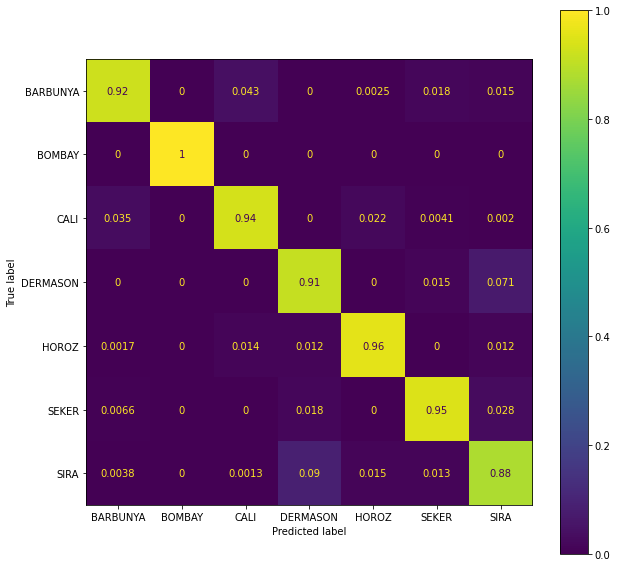

In [ ]:
best_models = [best_tree_model, best_forest_model, best_svm_model, best_log_model]
best_scores = [best_tree_score, best_forest_score, best_svm_score, best_log_score]
best = np.argmax(best_scores)
best_score = best_scores[best]
best_model = best_models[best]

steps = []
for step in best_model.estimator.steps:
  steps.append(step[0])
print(f"Pipeline of the best classifier: {steps}")

print("Normalized confusion matrix:")
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
results.to_excel("result.xlsx")

From this table it is possible to see, for each classifier, the pipeline that brings the best results in terms of *F1-score*.  

![j](https://raw.githubusercontent.com/RoboTuan/MML/main/Images/results.png)

# References
[1] https://scikit-learn.org/stable/modules/cross_validation.html#stratification  
[2] https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51  
[3] Understanding Machine Learning: From Theory to Algorithms. Shai Shalev-Shwartz and Shai Ben-David  
[4] An Introduction to Statistical Learning. Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani  
[5] https://imbalanced-learn.org/stable/common_pitfalls.html  
[6] SMOTE: Synthetic Minority Over-sampling Technique. N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer    
[7] SCUT: Multi-Class Imbalanced Data Classification using SMOTE and Cluster-based Undersampling. Astha Agrawal, Herna L. Viktor, Eric Paquet   
[8] https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8    
[9] https://en.wikipedia.org/wiki/Feature_scaling  
[10] https://rikunert.com/SMOTE_explained  
[11] Multiclass classification of dry beans using computer vision and machine learning techniques. Murat Koklu, Ilker Ali Ozkan  
[12] https://scikit-learn.org/stable/modules/cross_validation.html#stratification  
[13] Isolation Forest. Fei Tony Liu, Kai Ming Ting, Zhi-Hua Zhou  
[14] https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets  